## Differentially regulated genes in core, fast-core, accessory and pathogenicity regions

We can distinguish at least 4 different chromosomal categories on the Fol4287 genome: there's **core**, **fast-core**, **lineage-specific** and **accessory** chromosomes. The different 'speeds' are defined based differences in dispensability and sequence divergence within the _Fusarium oxysporum_ species complex (FOSC).  

First of all, we investigate whether different categories have low expression values, either in vitro or in vivo. Secondly, to see how strongly these different genome compartments are involved in infection, we used a dataset in which in vitro were compared to in planta conditions and determine whether differentially expressed genes are overrepresented in one or more chromosomal categories.  
  

### Chromosomal categories

In [1]:
'''We start with making a few dictionaries mapping scaffolds to chromosomes, to their length, etc. etc'''

###### Chromosomal categories: category -> chromosomes/chromosomal regions  
chr_categories = ['core', 'fast-core', 'lineage-specific', 'pathogenicity']
cat2chrs = {}

cat2chrs['core']             = ['chr01','chr02','chr04','chr05','chr07','chr08','chr09','chr10']
cat2chrs['fast-core']        = ['chr11','chr12','chr13']
cat2chrs['lineage-specific'] = ['chr01_LS', 'chr02_LS', 'chr03A', 'chr06A','chr15']
cat2chrs['pathogenicity']    = ['chr14', 'chr03P', 'chr06P']

chrs = []
for cat in chr_categories:
    chrs += cat2chrs[cat]

###### Chromosome -> scaffold
# Scaffolds per chromosome or chromosomal region, in case of e.g. chr01_LS or chr03P 
chr2scaffolds = {}
chr2scaffolds['chr01']    = [14,1]
chr2scaffolds['chr01_LS'] = [27]
chr2scaffolds['chr02']    = [6,10]
chr2scaffolds['chr02_LS'] = [31]
chr2scaffolds['chr03A']   = [32, 7, 25]
chr2scaffolds['chr03P']   = [47, 18]
chr2scaffolds['chr04']    = [8,4]
chr2scaffolds['chr05']    = [26, 2]
chr2scaffolds['chr06A']   = [9, 33]
chr2scaffolds['chr06P']   = [21, 53, 41, 42]
chr2scaffolds['chr07']    = [5, 13]
chr2scaffolds['chr08']    = [3, 29]
chr2scaffolds['chr09']    = [11, 17]
chr2scaffolds['chr10']    = [20, 15, 45]
chr2scaffolds['chr11']    = [35, 12]
chr2scaffolds['chr12']    = [19, 23]
chr2scaffolds['chr13']    = [16, 39]
chr2scaffolds['chr14']    = [22, 43, 51, 36]
chr2scaffolds['chr15']    = [37, 38, 24, 28]

# Also the other way around
###### Scaffold -> chromosome
scaffold2chromosome = {}
for chrom in chr2scaffolds.keys():
    for s in chr2scaffolds[chrom]:
        scaffold2chromosome['Supercontig_2.'+str(s)] = chrom

###### Scaffold -> length
genomeFilename = 'data/fusarium_oxysporum_f._sp._lycopersici_4287_2_supercontigs.contig2size.tab'
contig2size = {}
for line in open(genomeFilename).readlines():
    contig, size = line.strip().split('\t')
    contig2size[contig] = float(size)
    
# Chromosome -> size
chr2size = {}
for chrom in chr2scaffolds.keys():
    chrsize = 0
    for s in chr2scaffolds[chrom]:
        scaffold2chromosome['Supercontig_2.'+str(s)] = chrom
        chrsize += contig2size['Supercontig_2.'+str(s)] 
    chr2size[chrom] = chrsize

# Add unpositioned scaffolds, make this a separate 'chromosome'
chr2scaffolds ['US'] = []
for scaffold in contig2size:
    if scaffold not in scaffold2chromosome:
        scaffold2chromosome[scaffold] = 'US'
        chr2scaffolds['US'].append(int(scaffold.split('Supercontig_2.')[-1]))
        
###### Genes per scaffold, location per gene
scaffold2genes   = {}
genes2strand2pos = {}
all_genes = set([])
for line in open('data/fusarium_oxysporum_f._sp._lycopersici_4287_2_transcripts.gtf').readlines():
    data = line.split('\t')
    scaffold = data[0]
    gene = data[-1].split('gene_id "')[-1].split('"')[0]
    
    # add to genes per scaffold
    if scaffold not in scaffold2genes:
        scaffold2genes[scaffold] = set([gene])
    else: scaffold2genes[scaffold].add(gene)
    all_genes.add(gene)
    
print(len(all_genes))

20925


### RNA-seq data: RPKM values per gene  
We use the RNA-seq dataset that has been described in _van der Does et al., PLoS Genetics 2016_, and the RPKM values used here have been published as S1 Data in the Supplemental Material of _van der Does et al., PLoS Genetics 2016_: https://doi.org/10.1371/journal.pgen.1006401.s013 , RPKM sheet. The file is not exactly the same as I downloaded it: I changed the header of column Y from `Feature ID` to `Gene ID`, to distuingish between the two `Feature ID` columns in the file. 


In [2]:
import pandas

'''First we load the data into a DataFrames'''
# not reading as binary raises an UnicodeDecodeError, hence 'rb'
RPKMfile = open('data/journal.pgen.1006401.s013.ColumnYrenamed.xlsx', 'rb') 

RPKM_df  = pandas.read_excel(RPKMfile, sheetname = 'RPKM', skiprows = [20933, 20934])\
           .loc[:,['Gene ID', 'in vitro 2', 'in vitro1', 'in vitro 3', \
           'in planta 2', 'in planta 1', 'in planta 3']]
# skiprows is to avoid two empty rows that arise because this sheet also contains RPKM values for RNA-seq on 
# overexpressors that have extra two antibiotic-resistance genes in them (FOXG_BLE and FOXG_HYG)

RPKMfile.close()

''' Calculate mean RPKM per condition '''
# This is already in the sheet, recalculating is just an extra check, never hurts
RPKM_df = RPKM_df.assign(avg_RPKM_invitro = \
                         RPKM_df.loc[:,['in vitro1', 'in vitro 2', 'in vitro 3']].mean(axis = 1))
RPKM_df = RPKM_df.assign(avg_RPKM_inplanta = \
                         RPKM_df.loc[:,['in planta 1', 'in planta 2', 'in planta 3']].mean(axis = 1))
#print(RPKM_df)


low_expr_invitro  = set(RPKM_df.loc[RPKM_df['avg_RPKM_invitro']  <= 0.1]['Gene ID'])
low_expr_inplanta = set(RPKM_df.loc[RPKM_df['avg_RPKM_inplanta'] <= 0.1]['Gene ID'])

'''Perform a few checks:'''
genes_with_exprData = set(RPKM_df['Gene ID'])
missingExprData     = all_genes.difference(genes_with_exprData)
if len(missingExprData) > 0: # This should not be the case
    print('These genes are not in the RNA-seq dataset:')
    for gID in missingExprData:
        print(gID)
extraExprData = genes_with_exprData.difference(all_genes)

# Lotje (van der Does) manually added SIX genes that were not 
# correctly annotated by the Broad Institute to the gtf file 
# she used for mapping the RNA-seq data.
if len(extraExprData) > 0: 
    print('Extra genes that are in the RNA-seq dataset:')
    for gID in extraExprData:
        print(gID)
        

Extra genes that are in the RNA-seq dataset:
FOXG_SIX11
FOXG_SIX7
FOXG_PEG4
FOXG_SIX8-36
FOXG_SIX12
FOXG_SIX14
FOXG_SIX8-51


### RNA-seq data: differentially expressed genes  

DEseq output was aved as an excel file (`DEseq_output.xls`). We consider genes that have an adjusted P-value (`padj`) < 0.01 to be differentially regulated. `baseMean` is the mean of normalized counts of all samples, normalizing for sequencing depth, `baseMeanA` is the mean of normalized counts of all _in vitro_ samples, `baseMeanB` is the mean of normalized counts of all _in planta_ samples, hence if `padj` < 0.01 and `baseMeanA` < `baseMeanB` we consider a gene to be upregulated _in planta_. Similarly, if `padj` < 0.01 and `baseMeanA` > `baseMeanB` we consider a gene to be downregulated _in planta_.  

NB foldChange and log2FoldChange values are nan when baseMeanA = 0. In _van der Does et al., PLoS Genetics 2016_, 0-values were replaced by 0.1 (lower than lowest observed value,w hich was 0.2) to allow calculation of foldChange and log2FoldChange. We don't use these column here, so we just use the DEseq output values.


In [3]:
DEseq_file = open('data/DEseq_output.xlsx', 'rb')
DEseq_df   = pandas.read_excel(DEseq_file).loc[:,['id', 'baseMeanA', 'baseMeanB', 'padj']]
DEseq_file.close()

#print(DEseq_df)

DEG_df  = DEseq_df.loc[DEseq_df['padj']  < 0.01]
DEG_inplanta  = set(DEG_df['id'])
UP_inplanta   = set(DEG_df[(DEG_df['baseMeanA'] < DEG_df['baseMeanB'])]['id'])
DOWN_inplanta = set(DEG_df[(DEG_df['baseMeanA'] > DEG_df['baseMeanB'])]['id'])

# Sanity checks:
if len(UP_inplanta) + len(DOWN_inplanta) != len(DEG_inplanta):
    print("Error! Set sizes don't match:",\
          len(UP_inplanta),'+', len(DOWN_inplanta), 'should be', len(DEG_inplanta))
    
print('Upregulated genes:')  
print(len(UP_inplanta.intersection(low_expr_invitro)), 'out of', len(UP_inplanta),
         'have low in vitro expression')
print(len(UP_inplanta.intersection(low_expr_inplanta)), 'out of', len(UP_inplanta),
         'have low in planta expression')
print('Downregulated genes:')
print(len(DOWN_inplanta.intersection(low_expr_invitro)), 'out of', len(DOWN_inplanta),
         'have low in vitro expression')
print(len(DOWN_inplanta.intersection(low_expr_inplanta)), 'out of', len(DOWN_inplanta),
         'have low in planta expression')


Upregulated genes:
467 out of 896 have low in vitro expression
0 out of 896 have low in planta expression
Downregulated genes:
0 out of 140 have low in vitro expression
10 out of 140 have low in planta expression


### Are certain chromosomes enriched in DEGs?
Is there a clustering of genes involved in infection on certain chromosomes? We calculate the fraction of genes that differentially expressed _in planta_ upregulated _in planta_, downregulated _in planta_, has low _in vitro_ expression levels, or has low _in planta_ expression levels.  
  

In [4]:
from scipy import stats

M      = len(all_genes)
nDEG   = len(DEG_inplanta)
nUP    = len(UP_inplanta)
nDOWN  = len(DOWN_inplanta)
nLowIV = len(low_expr_invitro)
nLowIP = len(low_expr_inplanta)

# Store the fraction of genes with a certain property (e.g. upregulated)
# per chromosome or chromosomal category in a dictionary
chromCat2subsetRelsize       = {}
chromCat2subsetEnrichmPvalue = {}
nTests = 0   


for cat in chr_categories:
    cat_genes = set([])
    for chr in cat2chrs[cat]:
        
        # get number of genes on this chromosome
        chr_genes = set([])
        for scaffold in chr2scaffolds[chr]:
            chr_genes = chr_genes.union(scaffold2genes['Supercontig_2.'+str(scaffold)])
        cat_genes = cat_genes.union(chr_genes)
                 
        chr_genes = set([])
        for scaffold in chr2scaffolds[chr]:
            chr_genes = chr_genes.union(scaffold2genes['Supercontig_2.'+str(scaffold)])

        Nchr = len(chr_genes) 
    
        # calculate fraction of genes that belongs to a certain category (e.g. Upregulated)
        chromCat2subsetRelsize[chr] = {}
        chromCat2subsetRelsize[chr]['up']    = len(UP_inplanta.intersection(chr_genes))/float(Nchr)
        chromCat2subsetRelsize[chr]['down']  = len(DOWN_inplanta.intersection(chr_genes))/float(Nchr)
        chromCat2subsetRelsize[chr]['deg']   = len(DEG_inplanta.intersection(chr_genes))/float(Nchr)
        chromCat2subsetRelsize[chr]['lowIV'] = len(low_expr_invitro.intersection(chr_genes))/float(Nchr)
        chromCat2subsetRelsize[chr]['lowIP'] = len(low_expr_inplanta.intersection(chr_genes))/float(Nchr)
    
        # Test for enrichment of genes with this property, on this chromosome
        print('***  ', chr, '   ***')
        chromCat2subsetEnrichmPvalue[chr] = {}
        print('DEG:', stats.hypergeom.sf(len(DEG_inplanta.intersection(chr_genes)), M, nDEG, Nchr),\
            len(DEG_inplanta.intersection(chr_genes)), M, nDEG, Nchr)
        nTests += 1

        chromCat2subsetEnrichmPvalue[chr]['deg'] = stats.hypergeom.sf(len(DEG_inplanta.intersection(chr_genes)), \
                                                                 M, nDEG, Nchr)

        print('UP:', stats.hypergeom.sf(len(UP_inplanta.intersection(chr_genes)), M, nUP, Nchr), \
            len(UP_inplanta.intersection(chr_genes)), M, nUP, Nchr)
        nTests += 1

        chromCat2subsetEnrichmPvalue[chr]['up'] = stats.hypergeom.sf(len(UP_inplanta.intersection(chr_genes)), \
                                                                M, nUP, Nchr)
        print('DOWN:', stats.hypergeom.sf(len(DOWN_inplanta.intersection(chr_genes)), M, nDOWN, Nchr), \
            len(DOWN_inplanta.intersection(chr_genes)), M, nDOWN, Nchr)
        nTests += 1
        chromCat2subsetEnrichmPvalue[chr]['down'] = stats.hypergeom.sf(len(DOWN_inplanta.intersection(chr_genes)),\
                                                                  M, nDOWN, Nchr)

        print('LowRPKM_iV:', stats.hypergeom.sf(len(low_expr_invitro.intersection(chr_genes)), M, nLowIV, Nchr), \
            len(low_expr_invitro.intersection(chr_genes)), M, nLowIV, Nchr)
        nTests += 1
        chromCat2subsetEnrichmPvalue[chr]['lowIV'] = stats.hypergeom.sf(len(low_expr_invitro.intersection(chr_genes)), \
                                                                   M, nLowIV, Nchr)

        print('LowRPKM_iP:', stats.hypergeom.sf(len(low_expr_inplanta.intersection(chr_genes)), M, nLowIP, Nchr), \
            len(low_expr_inplanta.intersection(chr_genes)), M, nLowIP, Nchr)
        nTests += 1    
        chromCat2subsetEnrichmPvalue[chr]['lowIP'] = stats.hypergeom.sf(len(low_expr_inplanta.intersection(chr_genes)),\
                                                                   M, nLowIP, Nchr)


    # Now per category: core, fast-core, lineage-specific, pathogenicity
    print('\n')
    Ncat = len(cat_genes)  
    
    # Calculate fraction of genes that belongs to a certain category (e.g. Upregulated)
    chromCat2subsetRelsize[cat] = {}
    chromCat2subsetRelsize[cat]['up']    = len(UP_inplanta.intersection(cat_genes))/float(Ncat)
    chromCat2subsetRelsize[cat]['down']  = len(DOWN_inplanta.intersection(cat_genes))/float(Ncat)
    chromCat2subsetRelsize[cat]['deg']   = len(DEG_inplanta.intersection(cat_genes))/float(Ncat)
    chromCat2subsetRelsize[cat]['lowIV'] = len(low_expr_invitro.intersection(cat_genes))/float(Ncat)
    chromCat2subsetRelsize[cat]['lowIP'] = len(low_expr_inplanta.intersection(cat_genes))/float(Ncat)
    
    # Test for enrichment of genes with this property, on chromosomes of this category
    print('***  ', cat, '   ***')
    chromCat2subsetEnrichmPvalue[cat] = {}
    print('DEG:', stats.hypergeom.sf(len(DEG_inplanta.intersection(cat_genes)), M, nDEG, Ncat),\
        len(DEG_inplanta.intersection(cat_genes)), M, nDEG, Ncat)
    nTests += 1
    chromCat2subsetEnrichmPvalue[cat]['deg'] = stats.hypergeom.sf(len(DEG_inplanta.intersection(cat_genes)),\
                                                                 M, nDEG, Ncat)
    print('UP:', stats.hypergeom.sf(len(UP_inplanta.intersection(cat_genes)), M, nUP, Ncat),\
        len(UP_inplanta.intersection(cat_genes)), M, nUP, Ncat)
    nTests += 1
    chromCat2subsetEnrichmPvalue[cat]['up'] = stats.hypergeom.sf(len(UP_inplanta.intersection(cat_genes)), \
                                                                 M, nUP, Ncat)
    
    print('DOWN:', stats.hypergeom.sf(len(DOWN_inplanta.intersection(cat_genes)), M, nDOWN, Ncat),\
        len(DOWN_inplanta.intersection(cat_genes)), M, nDOWN, Ncat)
    nTests += 1
    chromCat2subsetEnrichmPvalue[cat]['down'] = stats.hypergeom.sf(len(DOWN_inplanta.intersection(cat_genes)), \
                                                                   M, nDOWN, Ncat)
    
    print('LowRPKM_iV:', stats.hypergeom.sf(len(low_expr_invitro.intersection(cat_genes)), M, nLowIV, Ncat), \
            len(low_expr_invitro.intersection(cat_genes)), M, nLowIV, Ncat)
    nTests += 1
    chromCat2subsetEnrichmPvalue[cat]['lowIV'] = stats.hypergeom.sf(len(low_expr_invitro.intersection(cat_genes)), \
                                                                    M, nLowIV, Ncat)
    
    print('LowRPKM_iP:', stats.hypergeom.sf(len(low_expr_inplanta.intersection(cat_genes)), M, nLowIP, Ncat), \
            len(low_expr_inplanta.intersection(cat_genes)), M, nLowIP, Ncat)
    nTests += 1    
    chromCat2subsetEnrichmPvalue[cat]['lowIP'] = stats.hypergeom.sf(len(low_expr_inplanta.intersection(cat_genes)), \
                                                                    M, nLowIP, Ncat)
    
    print('\n\n')
    
# Correct for multiple testing:
# print('*** For Bonferoni correction, multiply P-value with',nTests, '***\n\n')
print('Corrected P-values')
for cat in chr_categories:
    for chr in cat2chrs[cat]:
        print('\n',chr)
        for geneProp in ['deg', 'up', 'down', 'lowIV', 'lowIP']:
            print(geneProp, '\t', chromCat2subsetEnrichmPvalue[chr][geneProp]*float(nTests))
    
    print('\n*****  '+cat+'  *****')
    for geneProp in ['deg', 'up', 'down', 'lowIV', 'lowIP']:
            print(geneProp, '\t', chromCat2subsetEnrichmPvalue[cat][geneProp]*float(nTests))
    print('*****************\n\n\n')
                
        


    

***   chr01    ***
DEG: 0.999999998862 56 20925 1036 2214
UP: 0.999999988231 48 20925 896 2214
DOWN: 0.966737881245 8 20925 140 2214
LowRPKM_iV: 1.0 410 20925 7827 2214
LowRPKM_iP: 1.0 344 20925 5920 2214
***   chr02    ***
DEG: 0.996470335057 63 20925 1036 1737
UP: 0.996398361988 53 20925 896 1737
DOWN: 0.620348703456 10 20925 140 1737
LowRPKM_iV: 1.0 389 20925 7827 1737
LowRPKM_iP: 1.0 284 20925 5920 1737
***   chr04    ***
DEG: 0.497961623832 98 20925 1036 1991
UP: 0.84604140961 76 20925 896 1991
DOWN: 0.00665569271048 22 20925 140 1991
LowRPKM_iV: 1.0 501 20925 7827 1991
LowRPKM_iP: 1.0 380 20925 5920 1991
***   chr05    ***
DEG: 0.999967200613 55 20925 1036 1788
UP: 0.999986210907 44 20925 896 1788
DOWN: 0.539448669624 11 20925 140 1788
LowRPKM_iV: 1.0 453 20925 7827 1788
LowRPKM_iP: 1.0 345 20925 5920 1788
***   chr07    ***
DEG: 0.942033119136 68 20925 1036 1648
UP: 0.901056523059 60 20925 896 1648
DOWN: 0.782127224526 8 20925 140 1648
LowRPKM_iV: 1.0 437 20925 7827 1648
LowRPKM

### Histogram of relative number of up- and downregulated genes on chromosomes

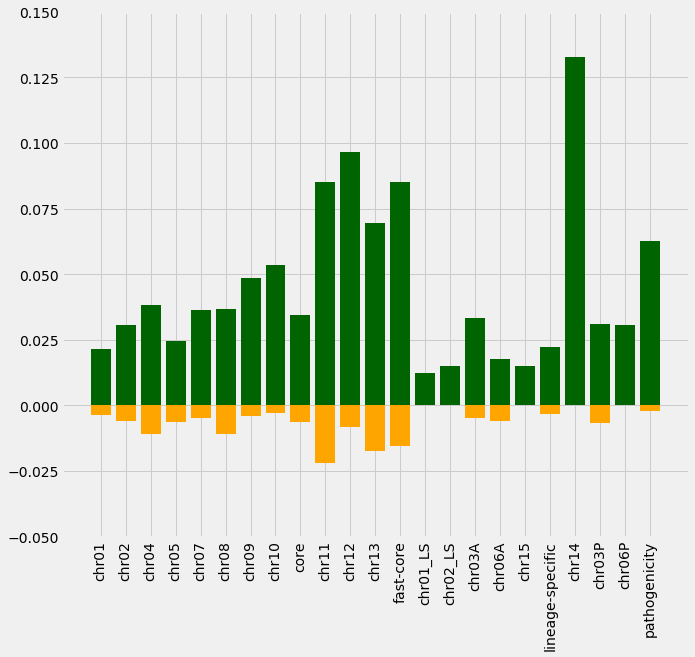

In [5]:
# Plot fractions of up- and downregulated genes per chromosome
from matplotlib import pyplot as plt 

%matplotlib inline
plt.rcParams['figure.figsize'] = (10,9)
plt.style.use('fivethirtyeight')
plt.figure()

# chromosome names and categories on x-axis
# fraction of up- and downregulated genes in lists
fracUP   = []
fracDOWN = []
xlabels = []
for cat in chr_categories:
    for chr in cat2chrs[cat]:
        xlabels.append(chr)
        fracUP.append(chromCat2subsetRelsize[chr]['up'])
        fracDOWN.append(-1*chromCat2subsetRelsize[chr]['down'])
        
    xlabels.append(cat)
    fracUP.append(chromCat2subsetRelsize[cat]['up'])
    fracDOWN.append(-1*chromCat2subsetRelsize[cat]['down'])

plt.bar(range(len(xlabels)), fracUP, color = 'darkgreen')
plt.bar(range(len(xlabels)), fracDOWN, color = 'orange')
plt.xticks(range(len(xlabels)), xlabels, rotation='vertical')
plt.ylim(-0.05, 0.15)
plt.savefig('Figures/fracUP_DOWN__perChr.eps')
plt.show()

### Can we link histone modifications to differences in expression levels?
The two different histone modifications we tested are typically associated with either euchromatin (H3K4me2) and thus transcriptionally active genes or (facultative) heterochromatin (H3K27me3) and thus inactive genes. Here we compare expression levels between the two histone modifications.   

We mapped ChIP-seq reads to the genome and predicted which regions are influenced by the histone modifications, so-called 'domains of enrichment' (DOEs). First we test whether DOEs of a mark are enriched for transcriptionally inactive genes (RPKM < 0.1) in either _in vitro_ or _in planta_ conditions.

#### Enrichment for genes with very low expression, _in vitro_ or _in planta_

In [6]:
genesInDOE_beds = ['data/ChIP-seq/overlap_Fol4287_genes.nr.H3K4me2_1358.bed', 'data/ChIP-seq/overlap_Fol4287_genes.nr.H3K4me2_806.bed',\
                  'data/ChIP-seq/overlap_Fol4287_genes.nr.H3K27me3_1360.bed', 'data/ChIP-seq/overlap_Fol4287_genes.nr.H3K27me3_808.bed']

gene_bed = 'data/Fol4287__genes.nr.bed' 

for cat in chr_categories:
    cat_genes = set([])
    for chr in cat2chrs[cat]:
        for scaffold in chr2scaffolds[chr]:
            cat_genes = cat_genes.union(scaffold2genes['Supercontig_2.'+str(scaffold)])
            

for bed_fname in genesInDOE_beds:    
    
    genes_inDOE = set([])
    for line in open(bed_fname).readlines():
        genes_inDOE.add(line.strip().split('\t')[-1].split('T')[0])
    
    hmark, expid = bed_fname.split('overlap_Fol4287_genes.nr.')[-1].split('.bed')[0].split('_')
    print('\n\n*****',hmark, expid, '*****')
    NinDOE = len(genes_inDOE)

    print('LOW in vitro', stats.hypergeom.sf(len(low_expr_invitro.intersection(genes_inDOE)), M, nLowIV, NinDOE),\
    len(low_expr_invitro.intersection(genes_inDOE)), M, nLowIV, NinDOE, len(low_expr_invitro.intersection(genes_inDOE))/float(nLowIV))
    
    print('LOW in planta', stats.hypergeom.sf(len(low_expr_inplanta.intersection(genes_inDOE)), M, nLowIP, NinDOE),\
    len(low_expr_inplanta.intersection(genes_inDOE)), M, nLowIP, NinDOE, len(low_expr_inplanta.intersection(genes_inDOE))/float(nLowIP))
    
    
print('\n\n')


        



***** H3K4me2 1358 *****
LOW in vitro 1.0 1455 20925 7827 10366 0.1858949789191261
LOW in planta 1.0 1262 20925 5920 10366 0.21317567567567566


***** H3K4me2 806 *****
LOW in vitro 1.0 503 20925 7827 6653 0.0642647246710106
LOW in planta 1.0 454 20925 5920 6653 0.07668918918918918


***** H3K27me3 1360 *****
LOW in vitro 0.0 6637 20925 7827 11628 0.8479621821898556
LOW in planta 0.0 4842 20925 5920 11628 0.8179054054054054


***** H3K27me3 808 *****
LOW in vitro 0.0 5375 20925 7827 9528 0.686725437587837
LOW in planta 1.43433906014e-297 3887 20925 5920 9528 0.6565878378378378





#### Difference in expression levels between the two histone marks



***** H3K4me2 1358 invitro *****
H3K4me2 1358
RPKM genes in DOE (mean, median):	 37.1060907454 5.465
RPKM genes not in DOE (mean, median):	 16.1860060572 0.0
MannwhitneyuResult(statistic=19084463.0, pvalue=0.0)
Ttest_indResult(statistic=100.96583885281099, pvalue=0.0)
10366 10566


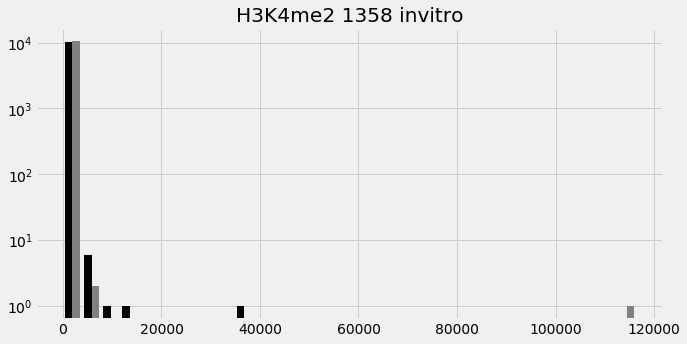



***** H3K4me2 1358 inplanta *****
H3K4me2 1358
RPKM genes in DOE (mean, median):	 31.1950318348 8.32666666667
RPKM genes not in DOE (mean, median):	 23.1856000379 0.213333333333
MannwhitneyuResult(statistic=23681190.0, pvalue=0.0)
Ttest_indResult(statistic=82.625511292249072, pvalue=0.0)
10366 10566


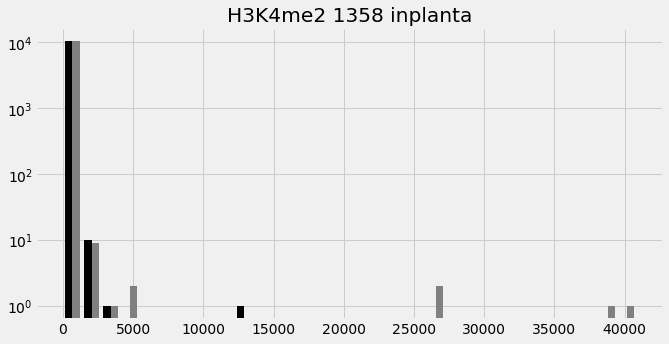



***** H3K4me2 806 invitro *****
H3K4me2 806
RPKM genes in DOE (mean, median):	 39.5484438098 9.53666666667
RPKM genes not in DOE (mean, median):	 20.4879389313 0.0866666666667
MannwhitneyuResult(statistic=14731872.5, pvalue=0.0)
Ttest_indResult(statistic=103.69598942453366, pvalue=0.0)
6653 14279


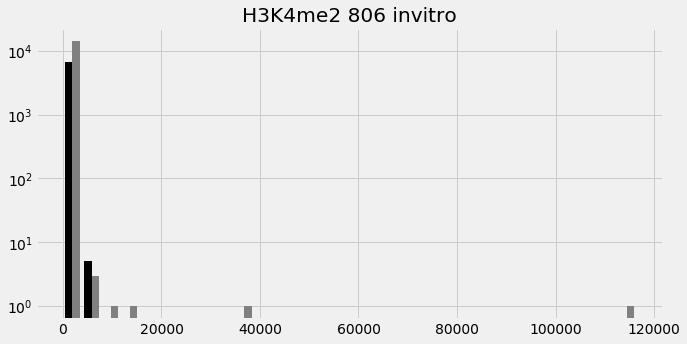



***** H3K4me2 806 inplanta *****
H3K4me2 806
RPKM genes in DOE (mean, median):	 37.3989573626 14.06
RPKM genes not in DOE (mean, median):	 22.3777215958 0.403333333333
MannwhitneyuResult(statistic=17668507.5, pvalue=0.0)
Ttest_indResult(statistic=89.678750565214756, pvalue=0.0)
6653 14279


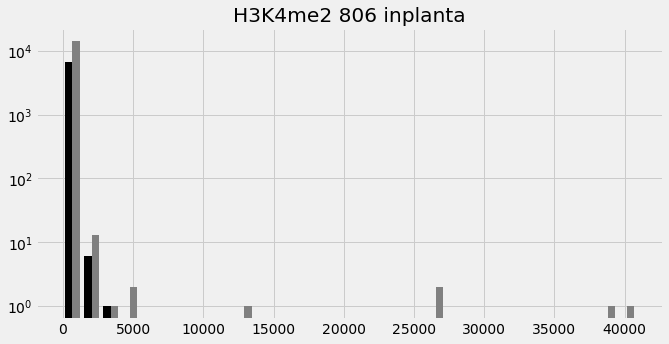



***** H3K27me3 1360 invitro *****
H3K27me3 1360
RPKM genes in DOE (mean, median):	 18.8608098269 0.0433333333333
RPKM genes not in DOE (mean, median):	 36.1510726569 6.17333333333
MannwhitneyuResult(statistic=19710076.0, pvalue=0.0)
Ttest_indResult(statistic=-96.098227977368751, pvalue=0.0)
11628 9304


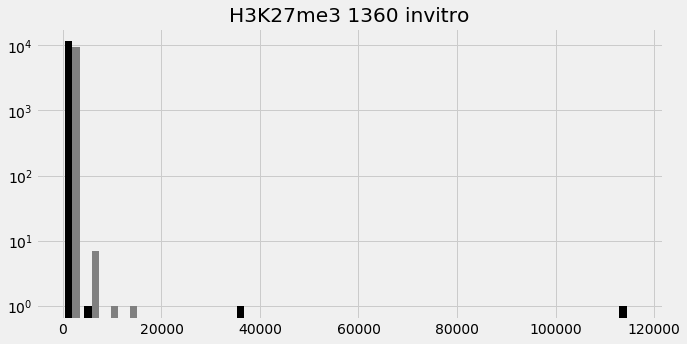



***** H3K27me3 1360 inplanta *****
H3K27me3 1360
RPKM genes in DOE (mean, median):	 23.7588757023 0.28
RPKM genes not in DOE (mean, median):	 31.3927927056 9.49333333333
MannwhitneyuResult(statistic=23981958.0, pvalue=0.0)
Ttest_indResult(statistic=-79.619369425738086, pvalue=0.0)
11628 9304


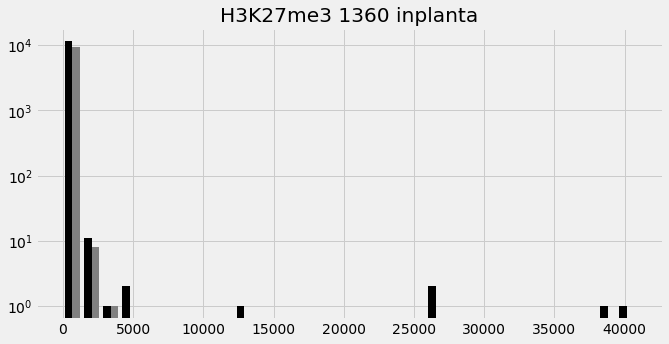



***** H3K27me3 808 invitro *****
H3K27me3 808
RPKM genes in DOE (mean, median):	 10.8848138819 0.0466666666667
RPKM genes not in DOE (mean, median):	 39.6310566468 3.71
MannwhitneyuResult(statistic=27026703.5, pvalue=0.0)
Ttest_indResult(statistic=-71.891379344331739, pvalue=0.0)
9528 11404


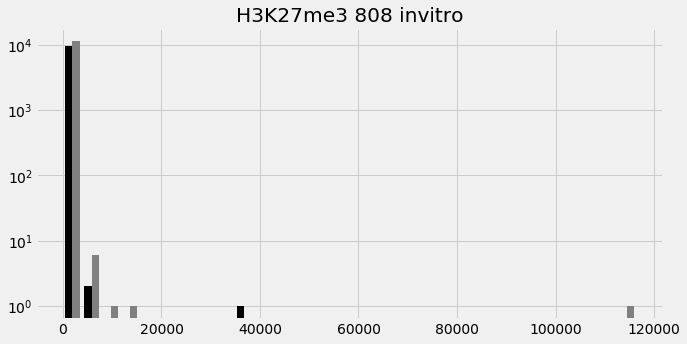



***** H3K27me3 808 inplanta *****
H3K27me3 808
RPKM genes in DOE (mean, median):	 10.7650689197 0.293333333333
RPKM genes not in DOE (mean, median):	 40.8433157956 6.14833333333
MannwhitneyuResult(statistic=30210407.0, pvalue=0.0)
Ttest_indResult(statistic=-61.333273259514122, pvalue=0.0)
9528 11404


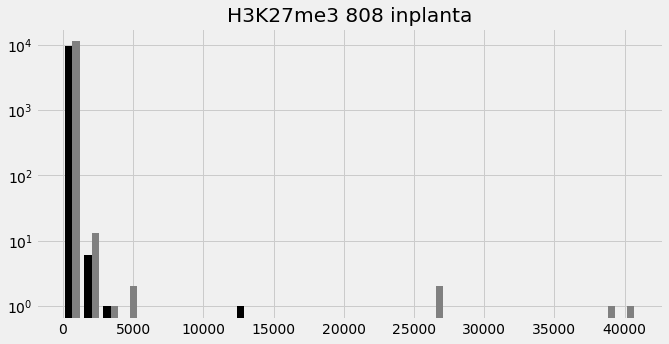

In [30]:
import scipy
import numpy as np
#low_expr_invitro  = set(RPKM_df.loc[RPKM_df['avg_RPKM_invitro']  <= 0.1]['Gene ID'])
#low_expr_inplanta = set(RPKM_df.loc[RPKM_df['avg_RPKM_inplanta'] <= 0.1]['Gene ID'])

for bed_fname in genesInDOE_beds:    
    
    for condition in ['invitro', 'inplanta']:
       
        genes_inDOE = set([])
        for line in open(bed_fname).readlines():
            genes_inDOE.add(line.strip().split('\t')[-1].split('T')[0])

        hmark, expid = bed_fname.split('overlap_Fol4287_genes.nr.')[-1].split('.bed')[0].split('_')
        print('\n\n*****',hmark, expid, condition, '*****')
        NinDOE = len(genes_inDOE)

        RPKM_DOE    = list(RPKM_df.loc[RPKM_df['Gene ID'].isin(genes_inDOE)]['avg_RPKM_'+condition])
        RPKM_notDOE = list(RPKM_df.loc[~RPKM_df['Gene ID'].isin(genes_inDOE)]['avg_RPKM_'+condition])
        
        if len(RPKM_DOE) != len(genes_inDOE): 
            print ("Error!")
            print (len(RPKM_DOE), '!=', len(genes_inDOE))
        print(hmark, expid)
        print('RPKM genes in DOE (mean, median):\t', np.mean(RPKM_DOE), np.median(RPKM_DOE))
        print('RPKM genes not in DOE (mean, median):\t', np.mean(RPKM_notDOE), np.median(RPKM_notDOE))
        
           
        # We don't assume that RPKM values are normally distributed, hence we use a Mann-Whitney U test...
        print(scipy.stats.mannwhitneyu(RPKM_DOE, RPKM_notDOE))
        
        # ...Or rank the data before applying a T-Test
        RPKM = RPKM_DOE + RPKM_notDOE
        
        #  get a list of ranks, where each value is the rank of the value with the same index in list 'RPKM'
        RPKM_rank          = scipy.stats.rankdata(RPKM, method='average') 
        RPKM_DOE_ranked    = RPKM_rank[:len(RPKM_DOE)]
        RPKM_notDOE_ranked = RPKM_rank[len(RPKM_DOE):]
        print(scipy.stats.ttest_ind(RPKM_DOE_ranked, RPKM_notDOE_ranked, equal_var = False))
    
        # plot, because it never hurts to take a look:
        print(len(RPKM_DOE), len(RPKM_notDOE))
        plt.figure(figsize = (10,5))
        plt.yscale('log', nonposy='clip')
        plt.hist([RPKM_DOE, RPKM_notDOE], bins = 30, color=['black','grey'])#, alpha=0.5)
        plt.title(hmark+' '+expid+' '+condition)
        plt.show()
        
        

### Can we link histone modifications to differential regulation during infection?

One hypothesis explaining the observation that core chromosome are enriched for H3K4me2, while accessory chromosome are enroched for H3K27me3, is that this allows for large-scale concerted regulation of genes involved in similar processes. E.g. removal of H3K27me3 from the accessory chromosomes upon infection can lead to an increase in gene expression of all genes that are located there.

Here we investigate whether genes that are located in an H3K27me3-enriched region are typically upregulated during infection and whether it is the other way around for genes in H3K4me2-ated regions.

In [31]:
for bed_fname in genesInDOE_beds:    
    
    genes_inDOE = set([])
    for line in open(bed_fname).readlines():
        genes_inDOE.add(line.strip().split('\t')[-1].split('T')[0])
    
    hmark, expid = bed_fname.split('overlap_Fol4287_genes.nr.')[-1].split('.bed')[0].split('_')
    print('\n\n*****',hmark, expid, '*****')
    NinDOE = len(genes_inDOE)

    print('DEG:', stats.hypergeom.sf(len(DEG_inplanta.intersection(genes_inDOE)), M, nDEG, NinDOE),\
    len(DEG_inplanta.intersection(genes_inDOE)), M, nDEG, NinDOE, len(DEG_inplanta.intersection(genes_inDOE))/float(nDEG))

    print('UP:', stats.hypergeom.sf(len(UP_inplanta.intersection(genes_inDOE)), M, nUP, NinDOE),\
    len(UP_inplanta.intersection(genes_inDOE)), M, nUP, NinDOE, len(UP_inplanta.intersection(genes_inDOE))/float(nUP))

    print('DOWN:', stats.hypergeom.sf(len(DOWN_inplanta.intersection(genes_inDOE)), M, nDOWN, NinDOE),\
    len(DOWN_inplanta.intersection(genes_inDOE)), M, nDOWN, NinDOE, len(DOWN_inplanta.intersection(genes_inDOE))/float(nDOWN))
 
    
print('\n\n')





***** H3K4me2 1358 *****
DEG: 1.0 300 20925 1036 10366 0.28957528957528955
UP: 1.0 231 20925 896 10366 0.2578125
DOWN: 0.490049579357 69 20925 140 10366 0.4928571428571429


***** H3K4me2 806 *****
DEG: 1.0 95 20925 1036 6653 0.0916988416988417
UP: 1.0 70 20925 896 6653 0.078125
DOWN: 0.999856175561 25 20925 140 6653 0.17857142857142858


***** H3K27me3 1360 *****
DEG: 3.22070281938e-61 822 20925 1036 11628 0.7934362934362934
UP: 2.04588718194e-60 725 20925 896 11628 0.8091517857142857
DOWN: 0.000315330377642 97 20925 140 11628 0.6928571428571428


***** H3K27me3 808 *****
DEG: 6.99612199907e-48 697 20925 1036 9528 0.6727799227799228
UP: 1.61466083813e-41 603 20925 896 9528 0.6729910714285714
DOWN: 7.48497938325e-08 94 20925 140 9528 0.6714285714285714





#### Table with location, DEseq adjusted P-value, and RPKM per gene  


In [16]:
# Get location per gene from the gtf-file
gene2pos = {}
for line in open('data/fusarium_oxysporum_f._sp._lycopersici_4287_2_transcripts.gtf').readlines():
    tabs = line.split('\t')
    
    if tabs[2] == 'CDS':
        scaffold = tabs[0]
        gene = tabs[-1].split('gene_id "')[-1].split('"')[0]
     
        # Determine start-end positions of the gene
        start, end = map(int, tabs[3:5])
        strand     = tabs[6]
        
        if gene not in gene2pos:
            gene2pos[gene] = (scaffold, start, end, strand) 
        else:
            scaffold2, start2, end2, strand2 = gene2pos[gene]
            if scaffold2 != scaffold or strand2 != strand: 
                print('??? Parse error in gtf-file\n', line)
                print(gene, scaffold2, start2, end2, strand2)
            else:
                if start2 < start:
                    start = start2 # keep 'old' start site
                if end2 > end:
                    end = end2     # keep 'old' end site

                # otherwise replace:
                gene2pos[gene] = (scaffold, start, end, strand) 


# Order per scaffold
scaffold2start2geneInfo = {}
for gene in gene2pos:

    (scaffold, start, end, strand) = gene2pos[gene]
    if scaffold not in scaffold2start2geneInfo:
        scaffold2start2geneInfo[scaffold] = {}
        scaffold2start2geneInfo[scaffold][start] = [(gene, end, strand)]
    else:
        if start in scaffold2start2geneInfo[scaffold]:
            scaffold2start2geneInfo[scaffold][start].append((gene, end, strand))
        else:
            scaffold2start2geneInfo[scaffold][start] = [(gene, end, strand)]
            
##### Write to a file, order per chromosome
# get scaffolds per chromosome as they are, without separating categories as was done above
chr2scaffolds['chr03'] = [47, 18, 32, 7, 25]
chr2scaffolds['chr06'] = [9, 33, 41, 21, 53, 42]

outfile = open('Table_RNAseq_withLocations.tab', 'w')
# write header
outfile.write('Chromosome\tScaffold\tstart\tend\tstrand\tGene ID\tRPKM in vitro\tRPKM in planta\tadjusted P-value\n')
chrs = ['chr01', 'chr01_LS', 'chr02', 'chr02_LS', 'chr03', 'chr04','chr05', 'chr06', 'chr07', 'chr08', 'chr09', \
        'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'US']

# set Gene ID as index for the DataFrames for easy 'access':
RPKM_idf  = RPKM_df.set_index("Gene ID", drop = False)
DEseq_idf = DEseq_df.set_index("id", drop = False)

for chrom in chrs:
    scaffold_nrs = chr2scaffolds[chrom]
    for sc_nr in scaffold_nrs:
        scaffold = 'Supercontig_2.'+str(sc_nr)
        
        if scaffold in scaffold2start2geneInfo: # some unpositioned scaffolds don't have any genes on them 
            start_sites = list(scaffold2start2geneInfo[scaffold].keys())
            start_sites.sort()
            for s in start_sites:
                for (gene, end, strand) in scaffold2start2geneInfo[scaffold][s]:
                    # Location info
                    out = chrom+'\t'+scaffold+'\t'+str(s)+'\t'+str(end)+'\t'+strand+'\t'+gene
                    # RPKM in vitro
                    out += '\t'+str(RPKM_idf.loc[gene, 'avg_RPKM_invitro'])
                    # RPKM in planta
                    out += '\t'+str(RPKM_idf.loc[gene, 'avg_RPKM_inplanta'])

                    # DEseq P-value diff. regulation
                    out += '\t'+str(DEseq_idf.loc[gene, 'padj'])

                    outfile.write(out+'\n')
        else: 
            print(scaffold,'has no genes')
       
            
            

Supercontig_2.100 has no genes
Supercontig_2.103 has no genes
Supercontig_2.104 has no genes
Supercontig_2.105 has no genes
Supercontig_2.107 has no genes
Supercontig_2.81 has no genes
Supercontig_2.84 has no genes
Supercontig_2.86 has no genes
Supercontig_2.87 has no genes
Supercontig_2.88 has no genes
Supercontig_2.91 has no genes
Supercontig_2.90 has no genes
Supercontig_2.95 has no genes
Supercontig_2.99 has no genes
Supercontig_2.113 has no genes
Supercontig_2.112 has no genes
Supercontig_2.111 has no genes
Supercontig_2.110 has no genes
